<a href="https://colab.research.google.com/github/Sandwhaletree/2023.05_Tibame/blob/main/A12_%E9%80%B2%E9%9A%8E%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92_%E6%9D%8E%E6%99%BA%E6%8F%9A/017_3D_Chest_CT_Classification_PyTorch_0810.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D Image Classification from CT Scans

**Ref:** [Hasib Zunair](https://twitter.com/hasibzunair)<br>

In [ ]:
import os
import zipfile
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import nibabel as nib
from scipy import ndimage
import random
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torchvision
import torchsummary

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Download data

In [ ]:
!curl -L "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip" --output "CT-0.zip"
!curl -L "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip" --output "CT-23.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1016M  100 1016M    0     0   140M      0  0:00:07  0:00:07 --:--:--  140M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  996M  100  996M    0     0   125M      0  0:00:07  0:00:07 --:--:--  113M


In [ ]:
# Make a directory to store the data.
os.makedirs("MosMedData", exist_ok=True)

# Unzip data in the newly created directory.
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

In [ ]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]
# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))


CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


In [ ]:
normal_scan_paths[:3], abnormal_scan_paths[:3]

(['/content/MosMedData/CT-0/study_0008.nii.gz',
  '/content/MosMedData/CT-0/study_0085.nii.gz',
  '/content/MosMedData/CT-0/study_0004.nii.gz'],
 ['/content/MosMedData/CT-23/study_0977.nii.gz',
  '/content/MosMedData/CT-23/study_0959.nii.gz',
  '/content/MosMedData/CT-23/study_1097.nii.gz'])

In [ ]:
# Get volumn label
# 'CT-0': normal: 0
# 'CT-23': abmormal: 1
normal_scan_paths[0].split(os.sep)[-2]

'CT-0'

#### Visualize raw data

In [ ]:
def read_nifti_file(filepath):
    # Read file and get raw data
    return nib.load(filepath).get_fdata()

# HU value
def normalize(volume):
    # Normalize the volume -1000 ~ 400 -> 0~1
    min = -1000
    max = 400
    # 2D: pixel -> 3D: voxel
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 32
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate 90 degree for visulize
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    # add channel dim
    volume = np.expand_dims(volume, axis=-1) # (H, W, Slice, 1)
    return volume

In [ ]:
# read a sample data
volume = process_scan(abnormal_scan_paths[0])

Dimension of the CT scan is: (128, 128, 32, 1)


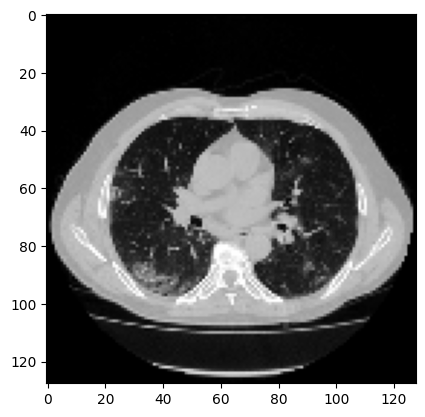

In [ ]:
print("Dimension of the CT scan is:", volume.shape)
plt.imshow(np.squeeze(volume[:, :, 15]), cmap="gray")

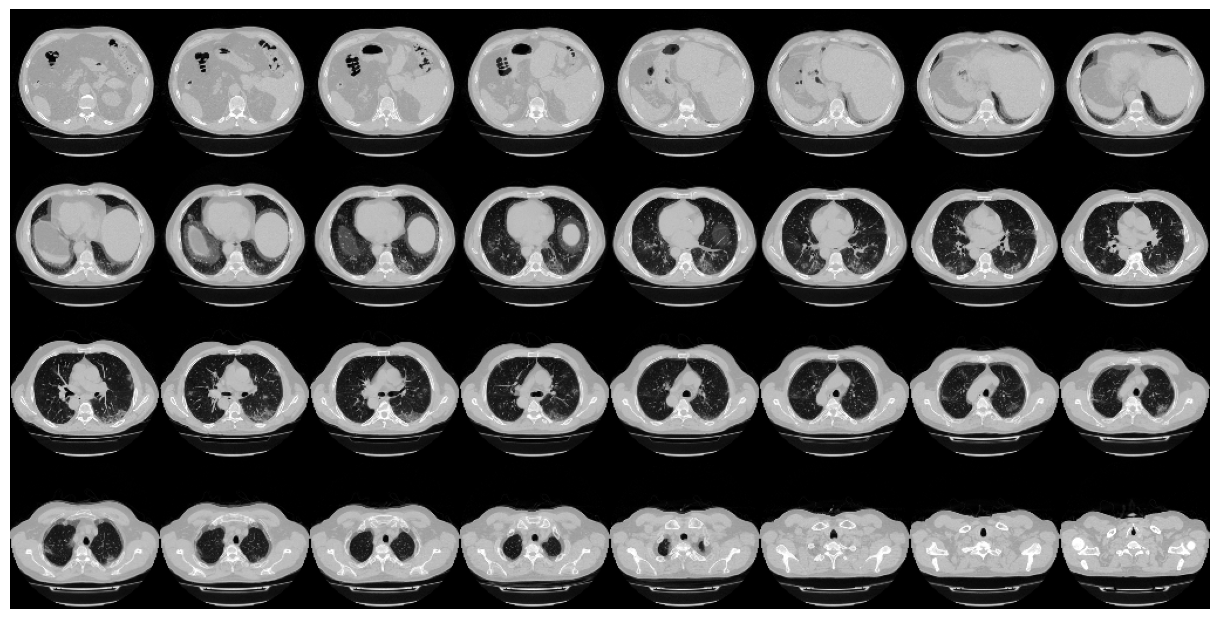

In [ ]:

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 8, 128, 128, volume[:, :, :32])

#### Dataset & Dataloader

In [ ]:
class CTDataset(torch.utils.data.Dataset):
    def __init__(self, paths, augmentation=False):
        super().__init__()
        self.paths = paths
        self.aug = augmentation

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        volume = self.process_scan(path)
        if self.aug:
            volume = self.rotate(volume)
        label = 1. if normal_scan_paths[0].split(os.sep)[-2] == 'CT-23' else 0.

        # To torch tensor
        # volume: (H, W, slice, 1) -> (1, H, W, slice)
        # label: 0. or 1.
        volume = torch.tensor(volume, dtype=torch.float).permute(3, 0, 1, 2)
        label = torch.tensor(label, dtype=torch.float)
        return volume, label

    def read_nifti_file(self, filepath):
        # Read file and get raw data
        return nib.load(filepath).get_fdata()

    def normalize(self, volume):
        # Normalize the volume -1000 ~ 400 -> 0~1
        min = -1000
        max = 400
        # 2D: pixel -> 3D: voxel
        volume[volume < min] = min
        volume[volume > max] = max
        volume = (volume - min) / (max - min)
        volume = volume.astype("float32")
        return volume

    def resize_volume(self, img):
        """Resize across z-axis"""
        # Set the desired depth
        desired_depth = 64
        desired_width = 128
        desired_height = 128
        # Get current depth
        current_depth = img.shape[-1]
        current_width = img.shape[0]
        current_height = img.shape[1]
        # Compute depth factor
        depth = current_depth / desired_depth
        width = current_width / desired_width
        height = current_height / desired_height
        depth_factor = 1 / depth
        width_factor = 1 / width
        height_factor = 1 / height
        # Rotate 90 degree for visulize
        img = ndimage.rotate(img, 90, reshape=False)
        # Resize across z-axis
        img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
        return img

    def process_scan(self, path):
        """Read and resize volume"""
        # Read scan
        volume = self.read_nifti_file(path)
        # Normalize
        volume = self.normalize(volume)
        # # Resize width, height and depth
        volume = self.resize_volume(volume)
        # add channel dim
        volume = np.expand_dims(volume, axis=-1) # (H, W, Slice, 1)
        return volume
    def rotate(self, volume):
        """Rotate the volume by a few degrees"""
        # pick angles at random
        angle = random.choice(np.arange(-20, 20))
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        return volume

In [ ]:
all_paths = normal_scan_paths + abnormal_scan_paths
train_paths, val_paths = train_test_split(all_paths,
                                          test_size=0.2)

train_ds = CTDataset(train_paths, augmentation=True)
val_ds = CTDataset(val_paths)

num_workers = 2
BS = 4
train_loader = torch.utils.data.DataLoader(train_ds,
                                           batch_size=BS,
                                           shuffle=True,
                                           num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_ds,
                                         batch_size=BS,
                                         num_workers=num_workers)

print('train : val = ', len(train_ds), len(val_ds))

train : val =  160 40


In [ ]:
volume, label = train_ds[1]
print(volume.shape, label)
# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
# plot_slices(4, 10, 128, 128, volume.squeeze(0)[:, :, :40])

torch.Size([1, 128, 128, 64]) tensor(0.)


#### Model

2D ResNet

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, activation=True):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv3d(in_ch, out_ch, kernel_size, stride, padding=kernel_size//2)
        self.bn = nn.BatchNorm3d(out_ch)
        self.use_act = activation
        self.act = nn.ReLU()
    def __call__(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.use_act:
            return self.act(x)
        else:
            return x

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = ConvBlock(in_ch, out_ch, stride=stride)
        self.conv2 = ConvBlock(out_ch, out_ch, activation=False)
        self.stride = stride
        if stride != 1:
            self.skip = ConvBlock(in_ch, out_ch, kernel_size=1, stride=stride, activation=False)
        self.act = nn.ReLU()
    def __call__(self, x):
        shortcut = self.skip(x) if self.stride != 1 else x
        x = self.conv1(x)
        x = self.conv2(x)
        x = x + shortcut
        x = self.act(x)
        return x

class ResNet3D(nn.Module):
    def __init__(self, in_ch=1, base_ch=64):
        super(ResNet3D, self).__init__()
        self.conv = nn.Sequential(
            ConvBlock(1, base_ch),
            nn.MaxPool3d(2),
        )
        self.block1 = nn.Sequential(
            ResBlock(base_ch, 64),
            ResBlock(64, 64),
        )
        self.block2 = nn.Sequential(
            ResBlock(64, 128, stride=2),
            ResBlock(128, 128, stride=2),
        )
        self.block3 = nn.Sequential(
            ResBlock(128, 256, stride=2),
            ResBlock(256, 256, stride=2),
        )
        self.pool = nn.AdaptiveAvgPool3d((1, 1, 1)) # GAP -> (C, 1, 1, 1)
        self.classifier = nn.Linear(256, 1)
    def __call__(self, x):
        x = self.conv(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1) # (C, 1, 1, 1) -> (C, )
        x = nn.Sigmoid()(self.classifier(x)) # (C, ) -> (1, )
        return x

In [ ]:
model = ResNet3D(1, 64).to(device)
torchsummary.summary(model, (1, 128, 128, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 64, 128, 128, 32]           1,792
       BatchNorm3d-2     [-1, 64, 128, 128, 32]             128
              ReLU-3     [-1, 64, 128, 128, 32]               0
         MaxPool3d-4       [-1, 64, 64, 64, 16]               0
            Conv3d-5       [-1, 64, 64, 64, 16]         110,656
       BatchNorm3d-6       [-1, 64, 64, 64, 16]             128
              ReLU-7       [-1, 64, 64, 64, 16]               0
            Conv3d-8       [-1, 64, 64, 64, 16]         110,656
       BatchNorm3d-9       [-1, 64, 64, 64, 16]             128
             ReLU-10       [-1, 64, 64, 64, 16]               0
           Conv3d-11       [-1, 64, 64, 64, 16]         110,656
      BatchNorm3d-12       [-1, 64, 64, 64, 16]             128
             ReLU-13       [-1, 64, 64, 64, 16]               0
           Conv3d-14       [-1, 64, 64,

#### Training

In [ ]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # Sets the model in training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in tqdm(enumerate(dataloader), leave=False):
        x, y = x.to(device), y.to(device) # move data to GPU

        # Compute prediction loss
        pred = model(x).squeeze(1)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        optimizer.zero_grad() # set prevision gradient to 0
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # log
        epoch_loss += loss.item()
        epoch_correct += (torch.round(pred) == y).type(torch.float).sum().item()
    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test_epoch(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # Sets the model in test mode.
    epoch_loss, epoch_correct = 0, 0

    # No training for test data
    with torch.no_grad():
        for batch_i, (x, y) in tqdm(enumerate(dataloader), leave=False):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x).squeeze(1)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (torch.round(pred) == y).type(torch.float).sum().item()
    return epoch_loss/num_batches, epoch_correct/size

In [ ]:
def train(epochs):
    # Model
    model = ResNet3D(1, 64)
    model = model.to(device)

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=1e-3)

    logs = {
        'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_epoch(train_loader, model, loss_fn, optimizer)
        val_loss, val_acc = test_epoch(val_loader, model, loss_fn)

        print(f'EPOCH: {epoch:04d} \
        train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
        val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

        logs['train_loss'].append(train_loss)
        logs['train_acc'].append(train_acc)
        logs['val_loss'].append(val_loss)
        logs['val_acc'].append(val_acc)
        # Save model
        torch.save(model.state_dict(), 'model.pth')

    # plot result
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(logs['train_loss'])
    plt.plot(logs['val_loss'])
    plt.subplot(1, 2, 2)
    plt.title('Acc.')
    plt.plot(logs['train_acc'])
    plt.plot(logs['val_acc'])
    plt.show()



In [ ]:
train(epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

EPOCH: 0000         train_loss: 0.0472, train_acc: 0.975         val_loss: 0.0042, val_acc: 1.000 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: ignored